# COMP 136 Day 24 - Variational Methods for GMMs


## Outline

* [Part 1: Variational Bayes optimization for GMMs](#part1)
* [Part 2: Model Selection with variational Bayes](#part2)
* [Part 3: Comparison to classic EM for GMMs](#part3)


## Key takeaways

* The method of "Variational Bayes" estimates a posterior distribution for all parameters (mixture weights $\pi$, locations $\mu_k$, cluster covariances $\Sigma_k$)
* By optimizing an objective that is based on a full marginal likelihood, the ELBO can be used for model selection ... simplest model that explains the data well will be strongly preferred
* In contrast, classic EM for GMMs also optimizes an ELBO, but this version still conditions on point estimates for $\pi, \mu, \Sigma$, and thus we cannot use this objective alone for model selection (see part 3)

# Setup

In [1]:
import numpy as np
import pandas as pd
import scipy.stats

np.set_printoptions(precision=3, suppress=True)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

In [3]:
def plot_GMM(pi_K, mu_KD, cov_KDD, color_list=['b', 'r', 'm', 'g', 'c', 'y'], ax_handle=None):
    ''' Visualize gaussian mixture model
    '''
    # Create new figure if one not provided
    if ax_handle is None:
        plt.figure()
        ax_handle = plt.gca()
    
    # Sort components from large to small
    sort_ids = np.argsort(pi_K)[::-1] 
    pi_K = pi_K[sort_ids]
    mu_KD = mu_KD[sort_ids]
    cov_KDD = cov_KDD[sort_ids]
    
    for i, (freq, mean, covar, color) in enumerate(zip(
            pi_K, mu_KD, cov_KDD, color_list)):
        if freq < 0.005:
            continue
        
        # Plot an ellipse to show the Gaussian component
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])        
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(ax_handle.bbox)
        ell.set_alpha(0.5)
        ax_handle.add_artist(ell)

        ax_handle.plot(
            mean[0], mean[1], color=color, marker='+', mew=2.0, label='pi[%d] = %.3f' % (i,freq))

# Create dataset

In [4]:
## Number of true clusters
K = 3

In [5]:
## Number of dimensions
D = 2

In [6]:
## Appearance probabilities
pi_K = np.asarray([0.6, 0.3, 0.1])

In [7]:
mu_KD = np.zeros((K, D))
mu_KD[0] = [-1, -1.0]
mu_KD[1] = [+1, +1.0]
mu_KD[2] = [0.2, -0.2]

In [8]:
cov_KDD = np.vstack([
    0.3 * np.eye(2)[np.newaxis,:,:],
    0.3 * np.eye(2)[np.newaxis,:,:],
    0.5 * np.asarray([[1.0, -0.8], [-0.8, 1.0]])[np.newaxis,:,:]])

In [9]:
## Number of observations
N = 1000

prng = np.random.RandomState(0)

In [10]:
truez_N = np.zeros(N)
x_ND = np.zeros((N, D))
for n in range(N):
    k = prng.choice(np.arange(K), p=pi_K)
    truez_N[n] = k
    
    x_ND[n] = prng.multivariate_normal(mu_KD[k], cov_KDD[k])

### Visualize dataset : color each point by its assigned cluster id

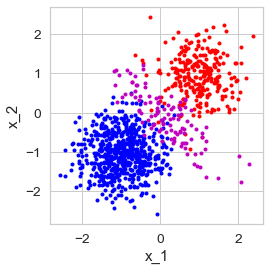

In [11]:
for (k, color) in [(0, 'b'), (1, 'r'), (2, 'm')]:
    plt.plot(x_ND[truez_N == k,0], x_ND[truez_N == k,1], color=color, marker='.', linestyle='')
plt.gca().set_aspect('equal');
plt.xlabel('x_1');
plt.ylabel('x_2');

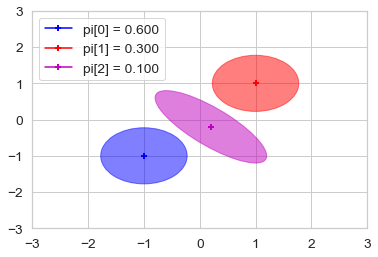

In [12]:
plot_GMM(pi_K, mu_KD, cov_KDD);
plt.xlim([-3, 3]);
plt.ylim([-3, 3]);
plt.legend(loc='upper left');

# Part 1 : Fit a GMM to data using 'Full Variational Bayes' Optimization Methods

Here, we'll use sklearn's built-in "BayesianGaussianMixture" implementation.

This is like the variational coordinate ascent algorithm described in Bishop PRML textbook Sec. 10.2

The model is:

$$
p( x, z | \pi, \mu, \Sigma ) = \prod_{n=1}^N \text{Cat}(z_n | \pi ) \text{MVNorm}(x_n | \mu_{z_n}, \Sigma_{z_n} )
$$

with a fully conjugate prior on parameters something like this (defer to sklearn documentation for correct description):

$$
p( \pi ) = \text{Dir}( \pi | a_0, \ldots a_0 )
\\
p( \mu, \Sigma ) = \prod_{k=1}^K \text{MVNorm}(\mu_k | m_0, \kappa_0 \Sigma_k ) \text{Wish}( \Sigma_k | n_0, S_0 )
$$

The goal of `sklearn.mixture.BayesianGaussianMixture` is to find an approximate posterior over all unknown random variables. In this way this is like the "EE" algorithm we discussed in lecture, rather than the classic "E/M" algorithm you implemented in CP4.

### Approximate posterior

\begin{align}
q( \pi ) &= \text{Dir}( a_1, \ldots a_K )
\\
q( \mu, \Sigma ) &= \prod_{k=1}^K \text{MVNorm}(\mu_k | m_k, \kappa_k \Sigma_k ) \text{Wish}( \Sigma_k | n_k, S_k )
\\
q( z ) &= \prod_{n=1}^N \text{Cat}( z_n | r_{n1}, \ldots r_{nK} )
\end{align}

The goal of the algorithm is to minimize the KL between this $q$ and the true posterior $p( z, \pi, \mu, \Sigma | x)$.

This is equivalent to maximizing the ELBO. 

The algorithm implemented does a coordinate ascent approach, as discussed in lecture

In [32]:
import sklearn.mixture

In [14]:
gmm = sklearn.mixture.BayesianGaussianMixture(
    n_components=3,

    # Prior on mixture weights pi
    weight_concentration_prior_type='dirichlet_distribution',
    weight_concentration_prior=0.5,

    # Prior on locations mu
    mean_prior=np.zeros(D),
    mean_precision_prior=1.0,

    # Prior on covariances Sigma
    covariance_type='full',
    covariance_prior=np.eye(D),
    degrees_of_freedom_prior=D + 1.0,

    # Initialization settings
    random_state=42,
    init_params='kmeans',
    n_init=1,

    # Optimization algorithm settings
    max_iter=100,
    tol=0.0001,
    verbose=2,
    verbose_interval=1,)

In [15]:
gmm.fit(x_ND)

Initialization 0
  Iteration 1	 time lapse 0.00649s	 ll change inf
  Iteration 2	 time lapse 0.00122s	 ll change 10.26674
  Iteration 3	 time lapse 0.00109s	 ll change 3.78400
  Iteration 4	 time lapse 0.00105s	 ll change 2.05885
  Iteration 5	 time lapse 0.00115s	 ll change 1.39327
  Iteration 6	 time lapse 0.00116s	 ll change 1.07539
  Iteration 7	 time lapse 0.00093s	 ll change 0.90047
  Iteration 8	 time lapse 0.00089s	 ll change 0.79437
  Iteration 9	 time lapse 0.00080s	 ll change 0.72557
  Iteration 10	 time lapse 0.00084s	 ll change 0.67888
  Iteration 11	 time lapse 0.00081s	 ll change 0.64614
  Iteration 12	 time lapse 0.00092s	 ll change 0.62248
  Iteration 13	 time lapse 0.00086s	 ll change 0.60461
  Iteration 14	 time lapse 0.00090s	 ll change 0.59007
  Iteration 15	 time lapse 0.00087s	 ll change 0.57668
  Iteration 16	 time lapse 0.00089s	 ll change 0.56231
  Iteration 17	 time lapse 0.00084s	 ll change 0.54463
  Iteration 18	 time lapse 0.00087s	 ll change 0.52116
  Ite

BayesianGaussianMixture(covariance_prior=array([[1., 0.],
       [0., 1.]]),
                        degrees_of_freedom_prior=3.0, mean_precision_prior=1.0,
                        mean_prior=array([0., 0.]), n_components=3,
                        random_state=42, tol=0.0001, verbose=2,
                        verbose_interval=1, weight_concentration_prior=0.5,
                        weight_concentration_prior_type='dirichlet_distribution')

In [16]:
gmm.lower_bound_

-538.3446085001409

### Inspect learned approximate posterior

$$
q( \pi ) = \text{Dir}( a_1, a_2, \ldots a_K )
$$

In [17]:
a_K = gmm.weight_concentration_
print(a_K)

[259.    634.045 108.455]


Mean of the pi vector

In [18]:
E_pi_K = a_K / np.sum(a_K)
print(E_pi_K)

[0.259 0.633 0.108]


Print 10 samples of pi from q

In [19]:
prng.dirichlet(a_K, size=5)

array([[0.266, 0.635, 0.099],
       [0.259, 0.623, 0.118],
       [0.273, 0.618, 0.109],
       [0.262, 0.62 , 0.118],
       [0.254, 0.634, 0.112]])

## Visualize learned GMM (use expected value of each parameter)

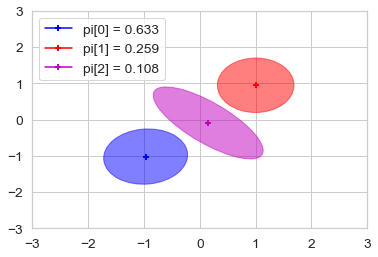

In [20]:
plot_GMM(E_pi_K, gmm.means_, gmm.covariances_)
plt.xlim([-3, 3]);
plt.ylim([-3, 3]);
plt.legend(loc='upper left');

# Part 2: Look at multiple runs of 'Bayesian GMM' across several K values

In [21]:
results_list = list()

best_gmm_per_K = dict()

for Kinit in [1, 2, 3, 4, 5, 6, 8, 10]:
    for trial in [101, 102, 103]:
        gmm = sklearn.mixture.BayesianGaussianMixture(
            n_components=Kinit,
            
            # Prior on mixture weights pi
            weight_concentration_prior_type='dirichlet_distribution',
            weight_concentration_prior=0.5,
            
            # Prior on locations mu
            mean_prior=np.zeros(D),
            mean_precision_prior=1.0,
            
            # Prior on covariances Sigma
            covariance_type='full',
            covariance_prior=np.eye(D),
            degrees_of_freedom_prior=D + 1.0,

            # Initialization settings
            random_state=trial,
            init_params='kmeans',
            n_init=1,
            
            # Optimization algorithm settings
            max_iter=100,
            tol=0.0001,
            verbose=0)
        gmm.fit(x_ND)
        print("completed trial %4d with K %4d : ELBO value % 9.5f" % (trial, Kinit, gmm.lower_bound_))
        results_list.append(dict(K=Kinit, elbo=gmm.lower_bound_))
        
        try:
            prev_best_elbo = best_gmm_per_K[Kinit].lower_bound_
        except KeyError:
            prev_best_elbo = -np.inf
        if gmm.lower_bound_ > prev_best_elbo:
            best_gmm_per_K[Kinit] = gmm

completed trial  101 with K    1 : ELBO value -744.27089
completed trial  102 with K    1 : ELBO value -744.27089
completed trial  103 with K    1 : ELBO value -744.27089
completed trial  101 with K    2 : ELBO value -570.80791
completed trial  102 with K    2 : ELBO value -570.80789
completed trial  103 with K    2 : ELBO value -570.80791
completed trial  101 with K    3 : ELBO value -538.34455
completed trial  102 with K    3 : ELBO value -538.34455
completed trial  103 with K    3 : ELBO value -538.34456
completed trial  101 with K    4 : ELBO value -549.64003
completed trial  102 with K    4 : ELBO value -543.48717


/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


completed trial  103 with K    4 : ELBO value -550.57837
completed trial  101 with K    5 : ELBO value -559.32673


/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


completed trial  102 with K    5 : ELBO value -554.45086
completed trial  103 with K    5 : ELBO value -555.30253


/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


completed trial  101 with K    6 : ELBO value -563.86519
completed trial  102 with K    6 : ELBO value -565.66680


/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


completed trial  103 with K    6 : ELBO value -563.81292
completed trial  101 with K    8 : ELBO value -582.62986


/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


completed trial  102 with K    8 : ELBO value -563.27466
completed trial  103 with K    8 : ELBO value -567.04445


/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


completed trial  101 with K   10 : ELBO value -571.66865
completed trial  102 with K   10 : ELBO value -583.95799
completed trial  103 with K   10 : ELBO value -563.42928


/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/Users/mhughes/miniconda3/envs/spr_2021s_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


## Demo 2a: Recreate Bishop's figure 10.7 : Plot of ELBO value vs model size (K)

In [22]:
result_df = pd.DataFrame(results_list)

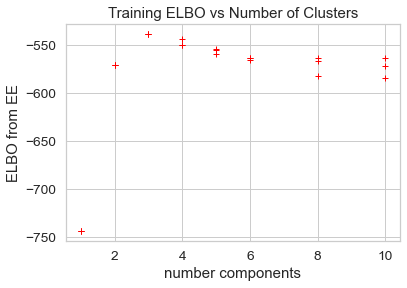

In [23]:
plt.plot(result_df['K'], result_df['elbo'], 'r+')
plt.xlabel('number components');
plt.ylabel('ELBO from EE');
plt.title('Training ELBO vs Number of Clusters');

## Discussion 2a : Does this figure show what you'd expect?

In [24]:
# TODO discuss

## Exercise 2b : Visualize the best GMM with K=2

No handles with labels found to put in legend.


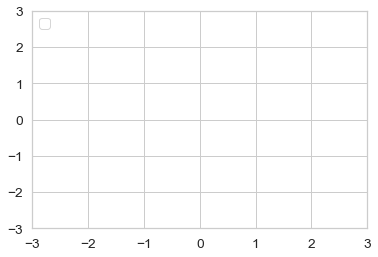

In [25]:
gmmK2 = best_gmm_per_K[2]

# TODO plot and interpret
plt.xlim([-3, 3]);
plt.ylim([-3, 3]);
plt.legend(loc='upper left');

## Exercise 2c: Visualize the best GMM with K=4

In [26]:
# TODO plot and interpret

# Part 3: Compare to classic GMM

In [27]:
results_EM_list = list()

for Kinit in [1, 2, 3, 4, 5, 6, 8, 10]:
    for trial in [101, 102, 103]:
        gmm = sklearn.mixture.GaussianMixture(
            n_components=Kinit,
            
            # Penalty / regularization on covariances Sigma
            covariance_type='full',
            reg_covar=0.000001,
            
            # Initialization settings
            random_state=trial,
            init_params='kmeans',
            n_init=1,
            
            # Optimization algorithm settings
            max_iter=10000,
            tol=0.0001,
            verbose=0)
        gmm.fit(x_ND)
        print("completed trial %4d with K %4d : ELBO value % 9.5f" % (trial, Kinit, gmm.lower_bound_))
        results_EM_list.append(dict(K=Kinit, elbo=gmm.lower_bound_))

completed trial  101 with K    1 : ELBO value  -2.56670
completed trial  102 with K    1 : ELBO value  -2.56670
completed trial  103 with K    1 : ELBO value  -2.56670
completed trial  101 with K    2 : ELBO value  -2.37759
completed trial  102 with K    2 : ELBO value  -2.37756
completed trial  103 with K    2 : ELBO value  -2.37759
completed trial  101 with K    3 : ELBO value  -2.32979
completed trial  102 with K    3 : ELBO value  -2.32979
completed trial  103 with K    3 : ELBO value  -2.32974
completed trial  101 with K    4 : ELBO value  -2.32750
completed trial  102 with K    4 : ELBO value  -2.32342
completed trial  103 with K    4 : ELBO value  -2.32732
completed trial  101 with K    5 : ELBO value  -2.32629
completed trial  102 with K    5 : ELBO value  -2.32051
completed trial  103 with K    5 : ELBO value  -2.32522
completed trial  101 with K    6 : ELBO value  -2.32367
completed trial  102 with K    6 : ELBO value  -2.31492
completed trial  103 with K    6 : ELBO value  -

In [28]:
result_EM_df = pd.DataFrame(results_EM_list)

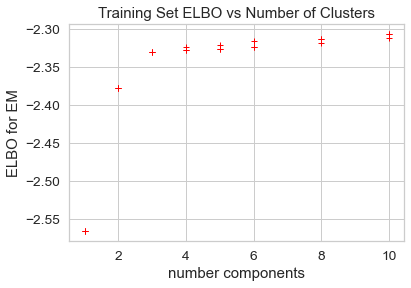

In [29]:
plt.plot(result_EM_df['K'], result_EM_df['elbo'], 'r+')
plt.xlabel('number components');
plt.ylabel('ELBO for EM');
plt.title('Training Set ELBO vs Number of Clusters');

## Discussion 3a : Does this figure show what you'd expect?

In [30]:
# TODO Discuss